# Dimensionality Reduction Techniques

In this module we are going to learn about the ways to reduce the number of dimensions (features) in our problems. This is a useful trick that sometimes improves performance and speeds up the algorithms we use. We are going to learn about how to select the most "optimal" features (in various senses), as well as using the PCA (Principal Component Analysis) to project the features down to a smaller subspace.

<b>Functions and attributes in this lecture: </b>
- `sklearn.datasets` - Submodule for pre-built datasets
 - `fetch_covtype` - Fetches the forest covertypes dataset
- `sklearn.feature_selection` - Submodule for selecting features
 - `VarianceThreshold` - Select features based on having high variance
- `sklearn.decomposition` - Submodule decomposition techniques
 - `PCA` - Implementation of Principal Component Analysis

In [1]:
# Non-sklearn packages
import numpy as np
import pandas as pd
import seaborn as sns

# Sklearn packages
from sklearn.datasets import fetch_covtype
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

In [2]:
# Importing the dataset
X, y = fetch_covtype(return_X_y=True, as_frame=True)

# Printing the description for the dataset
print(fetch_covtype()["DESCR"])

.. _covtype_dataset:

Forest covertypes
-----------------

The samples in this dataset correspond to 30×30m patches of forest in the US,
collected for the task of predicting each patch's cover type,
i.e. the dominant species of tree.
There are seven covertypes, making this a multiclass classification problem.
Each sample has 54 features, described on the
`dataset's homepage <https://archive.ics.uci.edu/ml/datasets/Covertype>`__.
Some of the features are boolean indicators,
while others are discrete or continuous measurements.

**Data Set Characteristics:**

    =================   ============
    Classes                        7
    Samples total             581012
    Dimensionality                54
    Features                     int
    =================   ============

:func:`sklearn.datasets.fetch_covtype` will load the covertype dataset;
it returns a dictionary-like 'Bunch' object
with the feature matrix in the ``data`` member
and the target values in ``target``. If optional a

## Checking out a multiclass dataset

In [3]:
# Looking at the data
X.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# The problem is a multi-class problem
y.head()

0    5
1    5
2    2
3    2
4    5
Name: Cover_Type, dtype: int32

In [5]:
# Some tree species are more common than others
y.value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

In [6]:
# There are not any missing values
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 54 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           581012 non-null  float64
 1   Aspect                              581012 non-null  float64
 2   Slope                               581012 non-null  float64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  float64
 4   Vertical_Distance_To_Hydrology      581012 non-null  float64
 5   Horizontal_Distance_To_Roadways     581012 non-null  float64
 6   Hillshade_9am                       581012 non-null  float64
 7   Hillshade_Noon                      581012 non-null  float64
 8   Hillshade_3pm                       581012 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  float64
 10  Wilderness_Area_0                   581012 non-null  float64
 11  Wilderness_Area_1         

Check the memory usage above! It's a quite large dataset.

## Reduction Based on Correlation

A very simple way to reduce the number of features is to look at which features have the most (linear) correlation with the target.

In [7]:
# Combine the features and the target
combined = pd.concat((X, y), axis=1)

<AxesSubplot:>

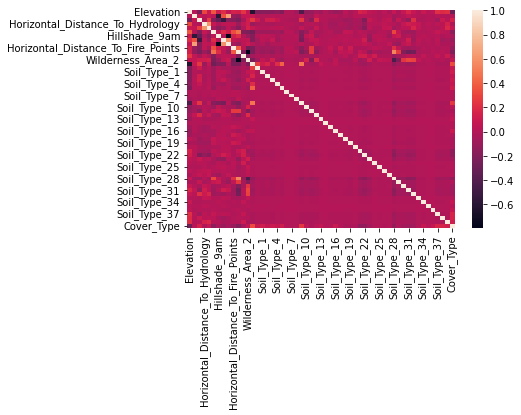

In [8]:
# Very hard to see with a heatmap
sns.heatmap(combined.corr())

In [9]:
# Just get the features that are most corrolated to the target 
most_correlated_feature_names = (np.abs(combined.corr()["Cover_Type"])
                                 .sort_values(ascending=False)
                                 .iloc[1:6]
                                 .index.to_list())

## Using Variance Threshold to Remove Features

The idea behind variance threshold is that features that vary little have a small effect on the outcome. In an extreme example, a feature that always have the same value gives no information about the values of the target.

In [10]:
# Initiating the class
variance_threshold = VarianceThreshold()

In [11]:
# Using the transformer
outcome = variance_threshold.fit_transform(X)

In [12]:
# Get the trimmed features
outcome = pd.DataFrame(outcome, columns=variance_threshold.get_feature_names_out())
outcome.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Seems the same as before
variance_threshold.n_features_in_ == len(outcome.columns)

True

The reason no features have been trimmed away is that the default `threshold` parameter for `VarianceThreshold` is 0. Hence nothing will be trimmed by default. Let's try to change that!

In [14]:
# Initiating the class with a threshold
variance_threshold_1 = VarianceThreshold(threshold=1)

In [15]:
# Using the transformer
outcome_1 = variance_threshold_1.fit_transform(X)

In [16]:
# Get the trimmed features
outcome_1 = pd.DataFrame(outcome_1, columns=variance_threshold_1.get_feature_names_out())
outcome_1.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0


Only the features that vary much are remaining. This is another way of retaining features that have an effect on the target.

## Implementing PCA

Implementing PCA is super simple in scikit-learn.

In [17]:
# Initiating a PCA instance
pca = PCA(n_components=5)

In [18]:
# Transform the data
result_pca = pca.fit_transform(X)

In [19]:
# The projection into 5 dimensions that best explain the variance
projection = pd.DataFrame(result_pca)

In [20]:
# Combine again with the targets
combined_with_projection = pd.concat((projection, y), axis=1)

In [21]:
# Some of the new features might have low variance
combined_with_projection.corr()

,0,1,2,3,4,Cover_Type
0,1.000000e+00,-2.156937e-15,5.505933e-15,1.812506e-15,-2.799970e-16,-0.167383
1,-2.156937e-15,1.000000e+00,7.341303e-15,-6.980601e-17,3.775686e-16,0.004308
2,5.505933e-15,7.341303e-15,1.000000e+00,7.302163e-16,1.349986e-17,-0.187592
3,1.812506e-15,-6.980601e-17,7.302163e-16,1.000000e+00,8.073083e-17,0.143250
4,-2.799970e-16,3.775686e-16,1.349986e-17,8.073083e-17,1.000000e+00,0.010209
Cover_Type,-1.673827e-01,4.307960e-03,-1.875918e-01,1.432505e-01,1.020885e-02,1.000000
